## Difference between Original and Smoothed

In this notebook I will calculate the difference between the original scans and the smoothed. Only in the difference the erosion can really be seen.

File configuration

In [1]:
# Adjust the frac parameter for loess smoothing
# to control the degree of smoothing applied to the scan data.
smoothed_dir = "../scandata/smoothed loess frac=0.20"

Libraries used:

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import os
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Reading the data
Loading NPY files

In [3]:
npy_files = [filename for filename in os.listdir(smoothed_dir) if filename.endswith(".npy")]
smoothed_point_clouds = [np.load(os.path.join(smoothed_dir, npy_file)) for npy_file in npy_files]

num_of_clouds = len(smoothed_point_clouds)
total_rows = 0

print(f"Loaded {num_of_clouds} smoothed point clouds.")

for i in range(num_of_clouds):
    print(f"Smoothed point cloud {npy_files[i]} shape: {smoothed_point_clouds[i].shape}")
    total_rows += smoothed_point_clouds[i].shape[1]
print(f"Total number of rows: {total_rows}")

Loaded 5 smoothed point clouds.
Smoothed point cloud 221111_144114__binary_onlylines114378to117271 loess frac=0.2.npy shape: (3, 5543532)
Smoothed point cloud 221111_144114__binary_onlylines145900to148050 loess frac=0.2.npy shape: (3, 3786525)
Smoothed point cloud 221111_144114__binary_onlylines25660to28100 loess frac=0.2.npy shape: (3, 3535680)
Smoothed point cloud 221111_144114__binary_onlylines47178to50517 loess frac=0.2.npy shape: (3, 3414927)
Smoothed point cloud 221111_144114__binary_onlylines86841to90142 loess frac=0.2.npy shape: (3, 4718054)
Total number of rows: 20998718


Boxplotting NPY (smoothed) files

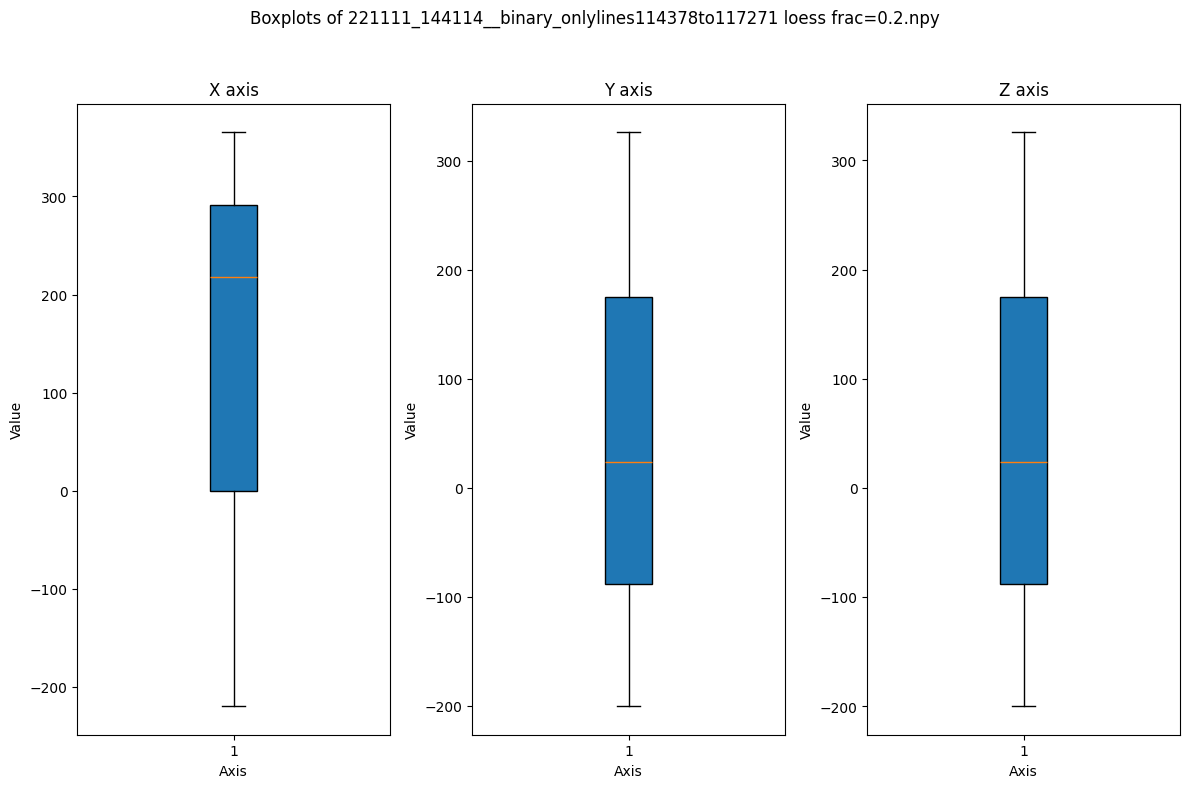

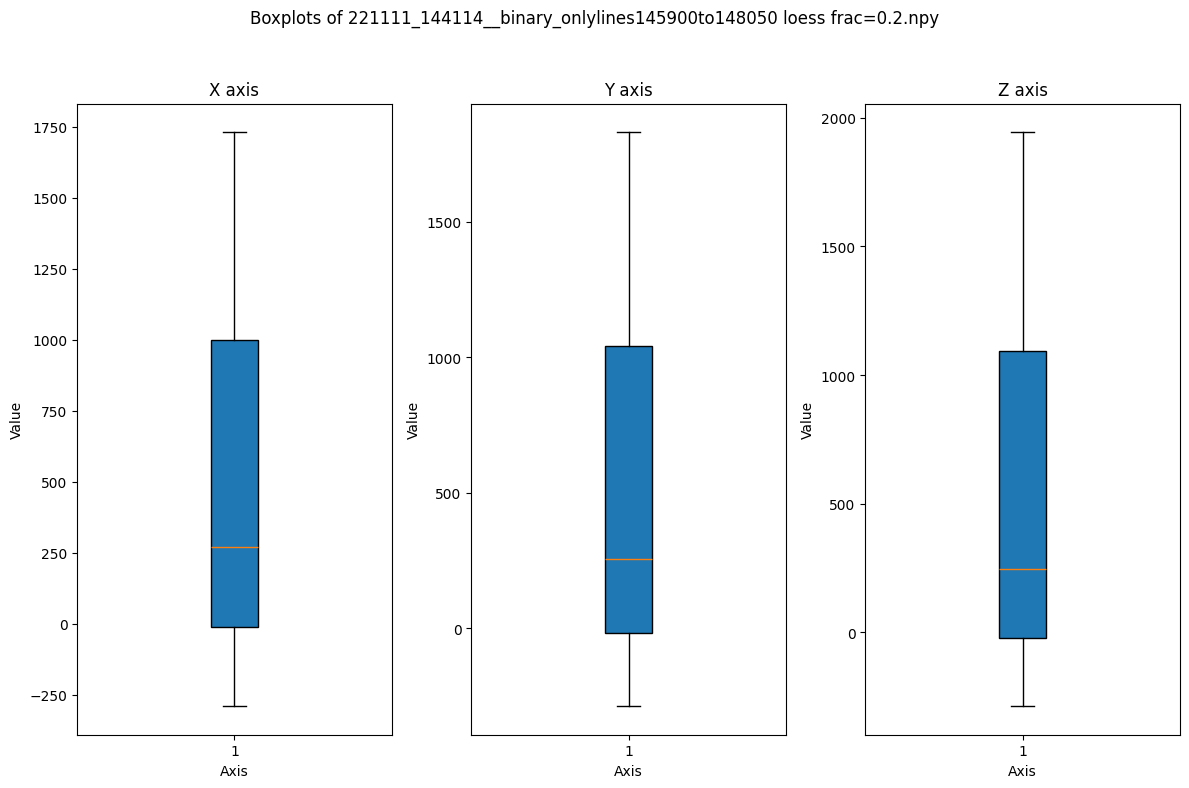

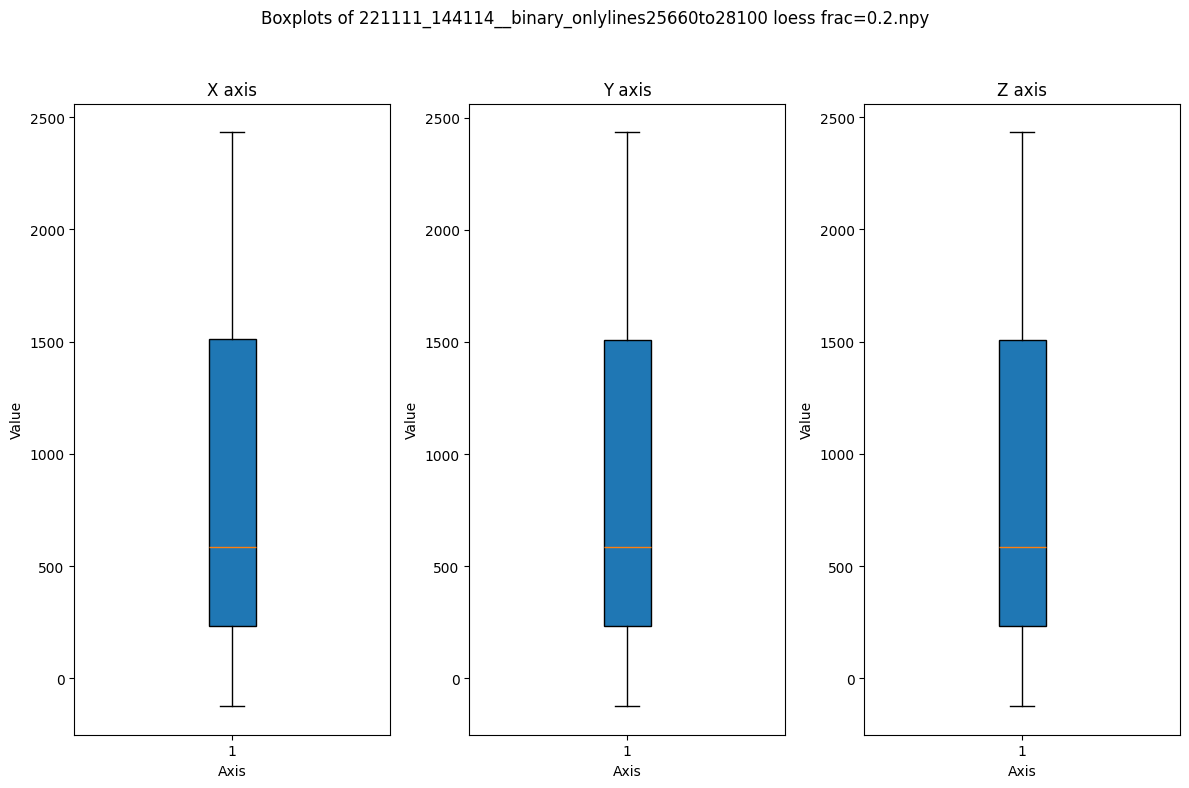

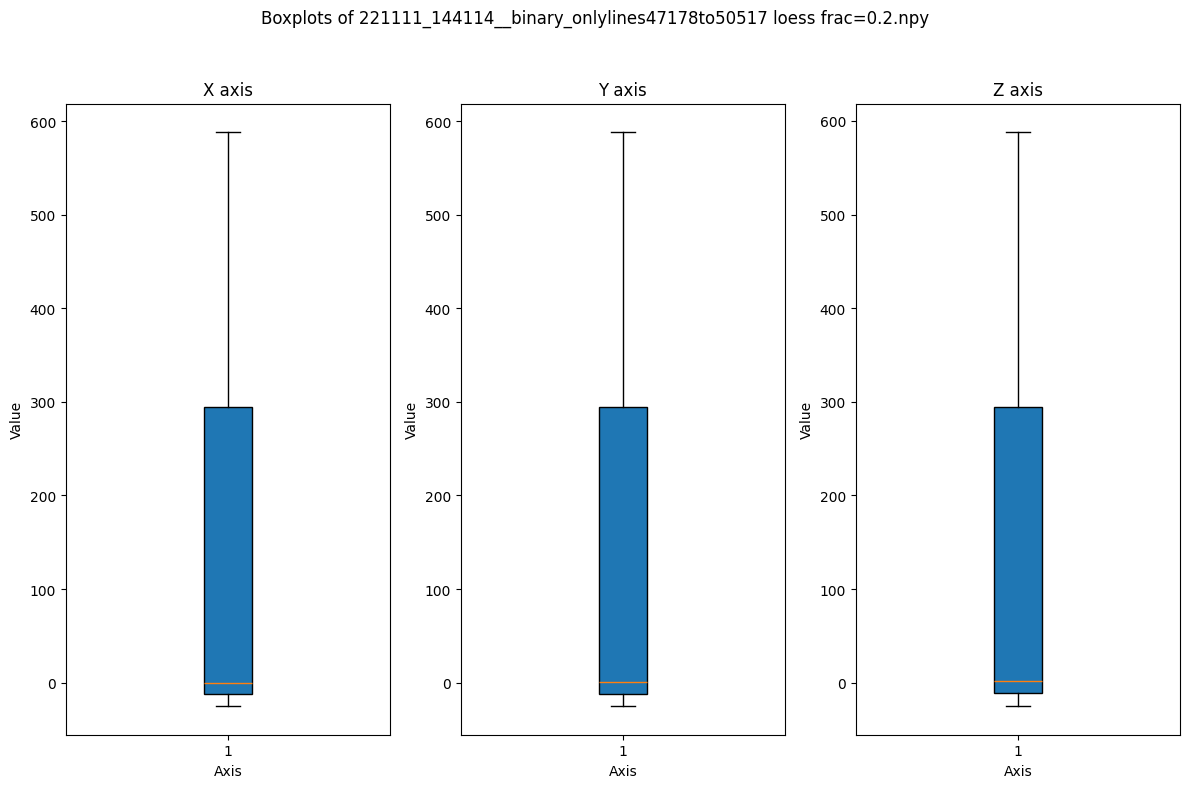

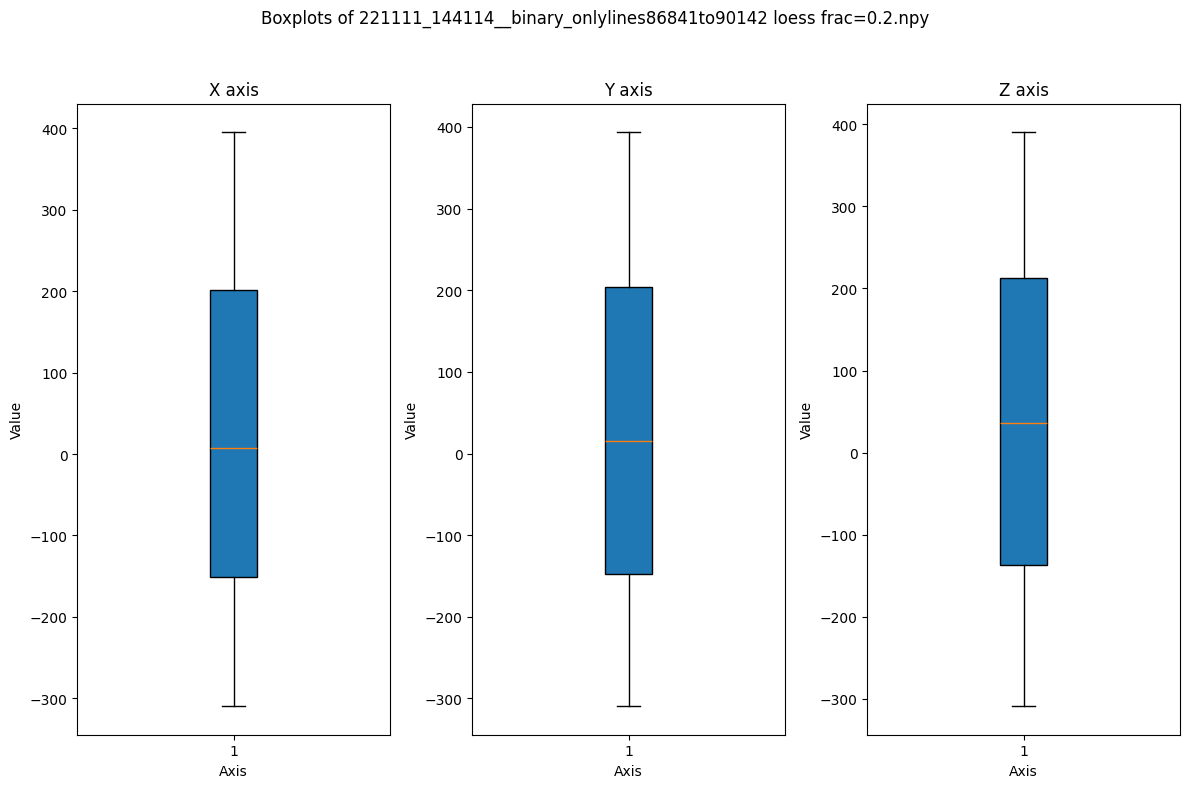

In [4]:
for cloud, fname in zip(smoothed_point_clouds, npy_files):
    plt.figure(figsize=(12, 8))
    plt.suptitle(f"Boxplots of {fname}")

    axes_labels = ['X', 'Y', 'Z']
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.boxplot(cloud[:, i], vert=True, patch_artist=True)
        plt.title(f"{axes_labels[i]} axis")
        plt.xlabel("Axis")
        plt.ylabel("Value")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In order to see erosion we need to calculate the difference between the smoothed and the original data. Loading PLY files with `open3d`.

In [5]:
# Load original PLY files from scandata/raw/ using Open3D
raw_dir = "../scandata/raw"
ply_files = [f for f in os.listdir(raw_dir) if f.endswith(".ply")]
original_point_clouds = []

for ply_file in ply_files:
    pcd = o3d.io.read_point_cloud(os.path.join(raw_dir, ply_file))
    original_point_clouds.append(pcd)
    print(f"Loaded original point cloud {ply_file} with {len(pcd.points)} points.")


Loaded original point cloud 221111_144114__binary_onlylines114378to117271.ply with 7408640 points.
Loaded original point cloud 221111_144114__binary_onlylines145900to148050.ply with 5506560 points.
Loaded original point cloud 221111_144114__binary_onlylines25660to28100.ply with 6248960 points.
Loaded original point cloud 221111_144114__binary_onlylines47178to50517.ply with 8550400 points.
Loaded original point cloud 221111_144114__binary_onlylines86841to90142.ply with 8453120 points.


The files have millions of rows indicating a missed measurement or no signal. 

In [6]:
for pcd, fname in zip(original_point_clouds, ply_files):
    points = np.asarray(pcd.points)
    if points.shape[1] >= 3:
        num_zero_z = np.sum(points[:, 2] == 0)
        print(f"{fname}: {num_zero_z} rows where Z == 0")
    else:
        print(f"{fname}: Not enough columns to check Z axis")

221111_144114__binary_onlylines114378to117271.ply: 1865108 rows where Z == 0
221111_144114__binary_onlylines145900to148050.ply: 1720035 rows where Z == 0
221111_144114__binary_onlylines25660to28100.ply: 2713280 rows where Z == 0
221111_144114__binary_onlylines47178to50517.ply: 5135473 rows where Z == 0
221111_144114__binary_onlylines86841to90142.ply: 3735066 rows where Z == 0


These are measurements we want to delete. They don't have value to use and they will only act as (sever) noise to our machine learning models later on.

In [7]:
cleaned_point_clouds = []
for pcd, fname in zip(original_point_clouds, ply_files):
    points = np.asarray(pcd.points)
    if points.shape[1] >= 3:
        mask = points[:, 2] != 0
        cleaned_points = points[mask]
        cleaned_point_clouds.append(cleaned_points)
        print(f"{fname}: {points.shape[0] - cleaned_points.shape[0]} rows removed, {cleaned_points.shape[0]} rows remain.")
    else:
        cleaned_point_clouds.append(points)
        print(f"{fname}: Not enough columns to check Z axis, no rows removed.")

221111_144114__binary_onlylines114378to117271.ply: 1865108 rows removed, 5543532 rows remain.
221111_144114__binary_onlylines145900to148050.ply: 1720035 rows removed, 3786525 rows remain.
221111_144114__binary_onlylines25660to28100.ply: 2713280 rows removed, 3535680 rows remain.
221111_144114__binary_onlylines47178to50517.ply: 5135473 rows removed, 3414927 rows remain.
221111_144114__binary_onlylines86841to90142.ply: 3735066 rows removed, 4718054 rows remain.


Offesetting scans to start at 0 on X axis.

In [8]:
offset_point_clouds = []
for points, fname in zip(cleaned_point_clouds, ply_files):
    if points.shape[1] >= 1:
        min_x = points[:, 0].min()
        offset_points = points.copy()
        offset_points[:, 0] -= min_x
        offset_point_clouds.append(offset_points)
        print(f"{fname}: X axis offset by {min_x}")
    else:
        offset_point_clouds.append(points)
        print(f"{fname}: Not enough columns to offset X axis")

221111_144114__binary_onlylines114378to117271.ply: X axis offset by 114378.0
221111_144114__binary_onlylines145900to148050.ply: X axis offset by 145900.0
221111_144114__binary_onlylines25660to28100.ply: X axis offset by 25660.0
221111_144114__binary_onlylines47178to50517.ply: X axis offset by 47178.0
221111_144114__binary_onlylines86841to90142.ply: X axis offset by 86841.0


Boxplotting PLY files

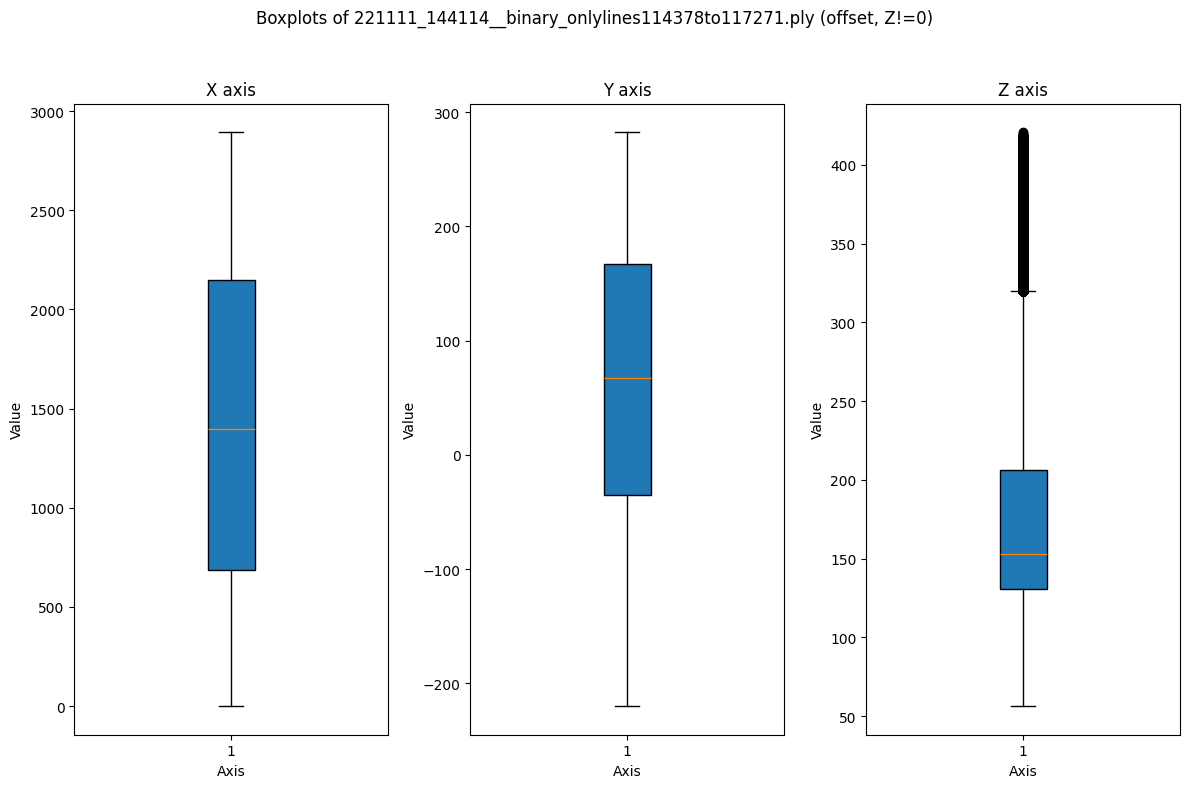

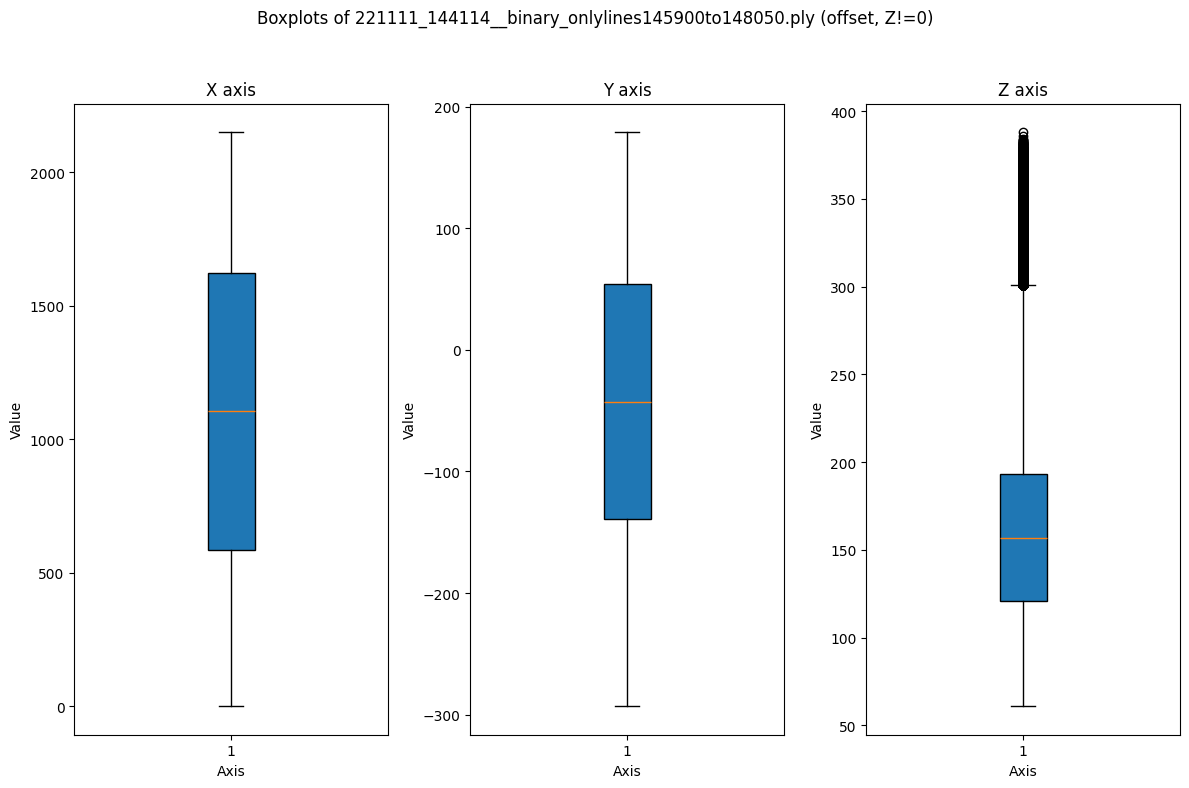

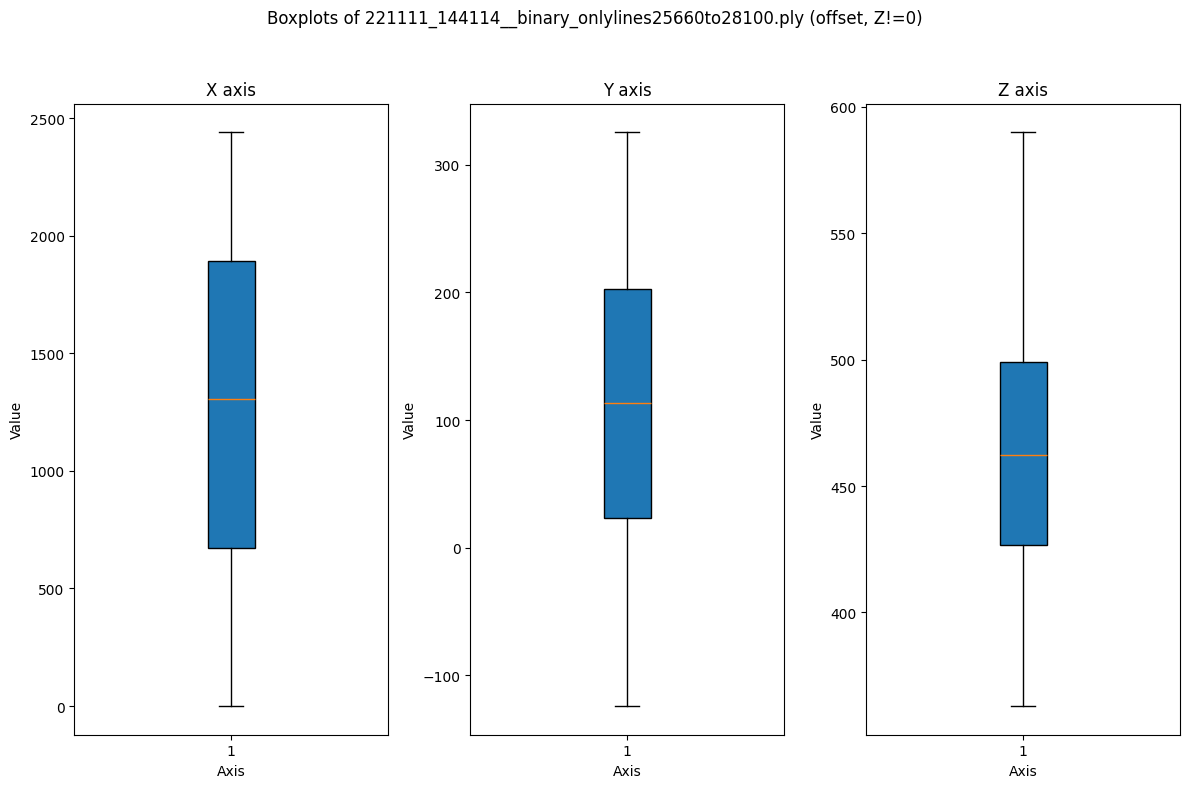

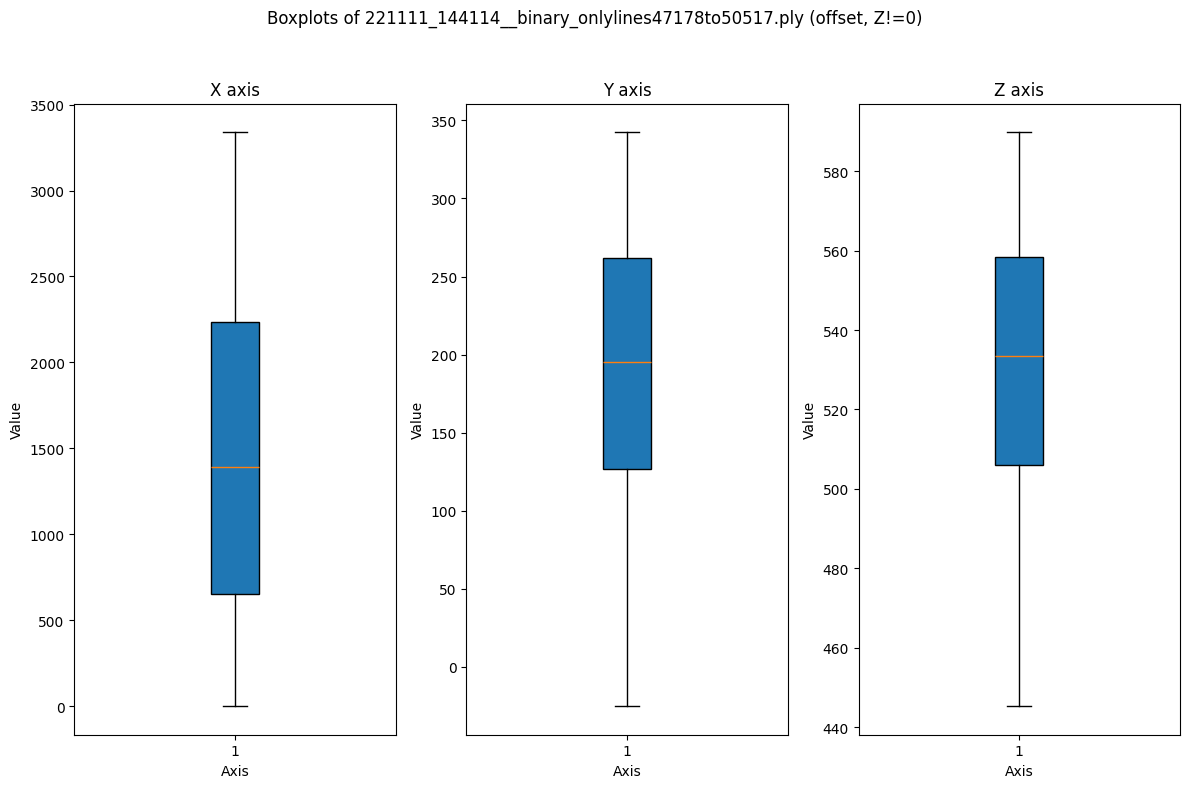

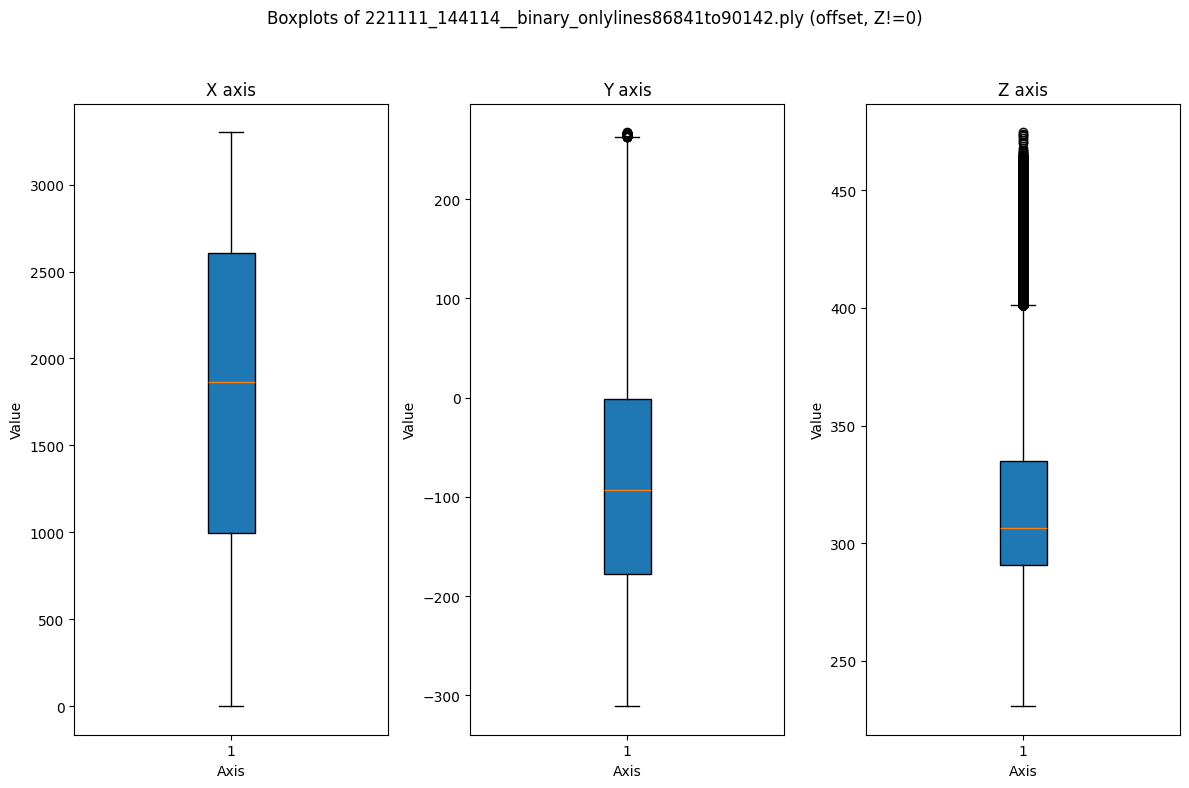

In [9]:
for points, fname in zip(offset_point_clouds, ply_files):
    plt.figure(figsize=(12, 8))
    plt.suptitle(f"Boxplots of {fname} (offset, Z!=0)")

    axes_labels = ['X', 'Y', 'Z']
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.boxplot(points[:, i], vert=True, patch_artist=True)
        plt.title(f"{axes_labels[i]} axis")
        plt.xlabel("Axis")
        plt.ylabel("Value")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Rendering

Let's render Smoothed and Raw scans separately before calculating the difference. Starting with Smoothed.

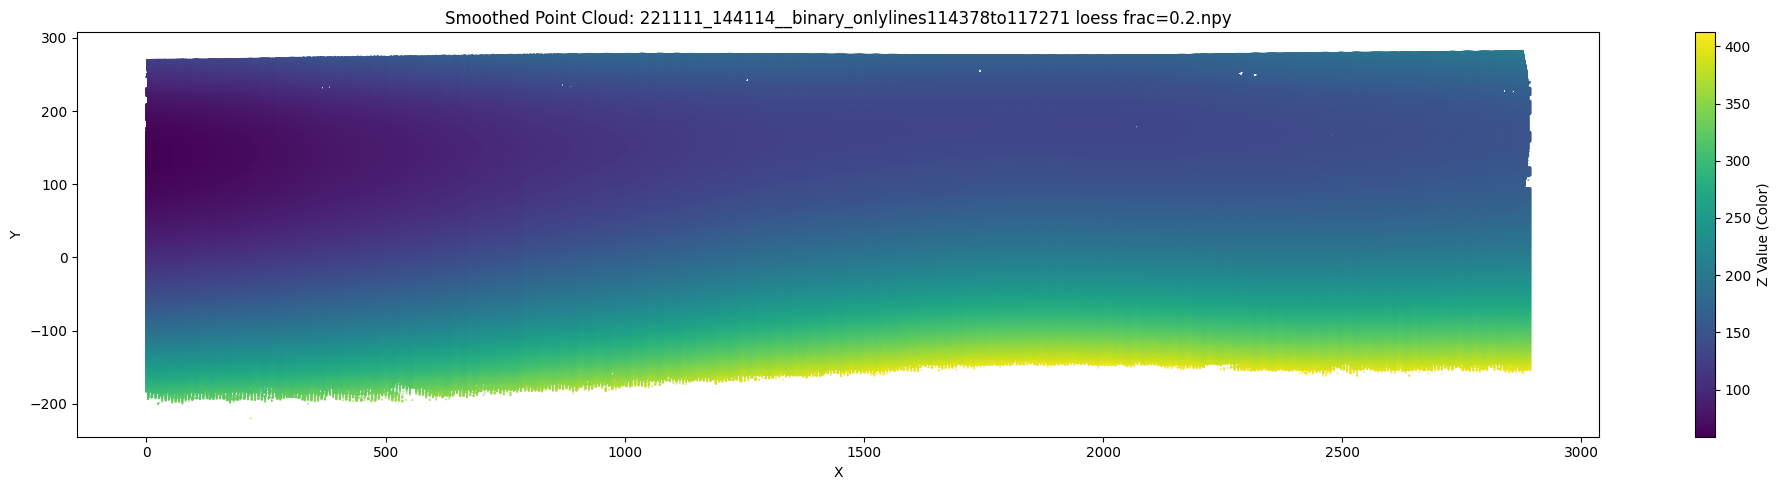

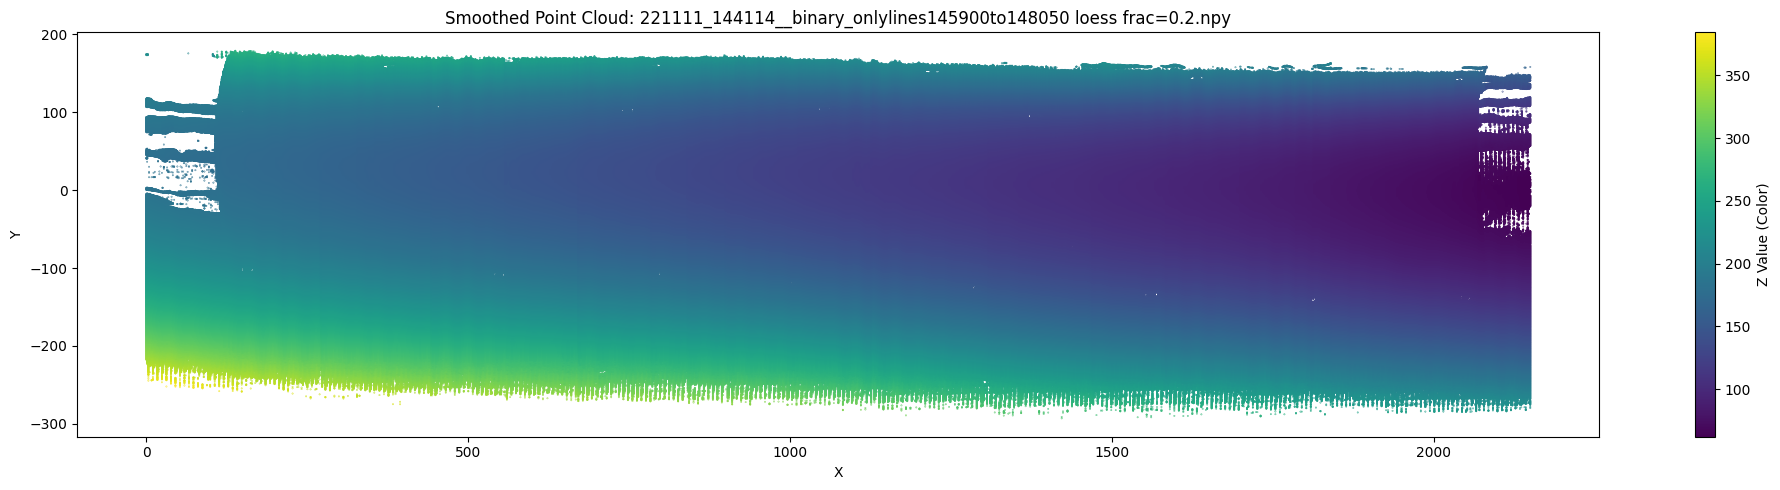

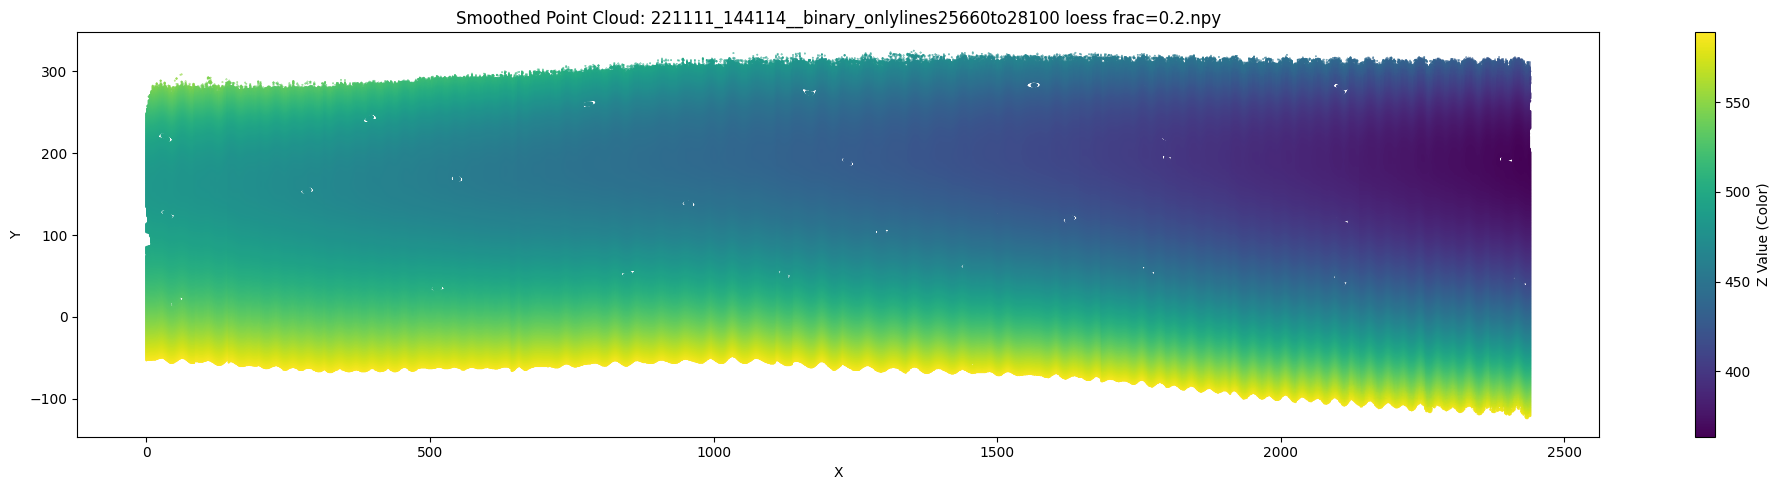

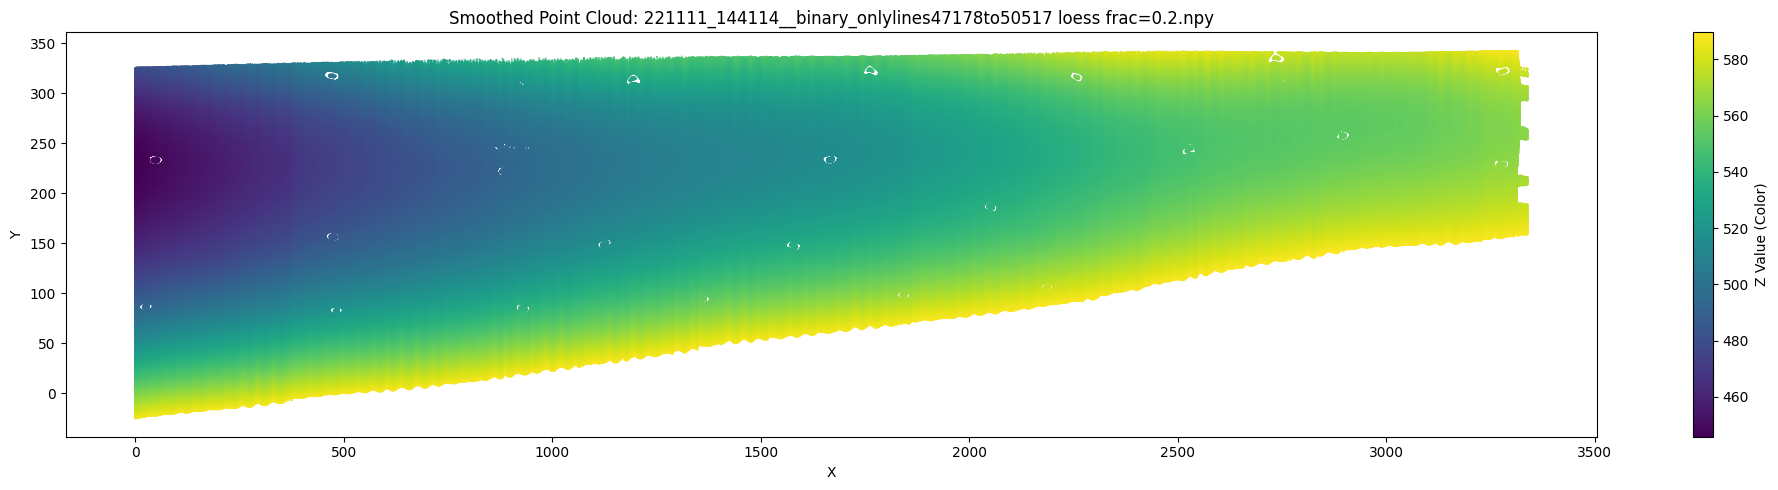

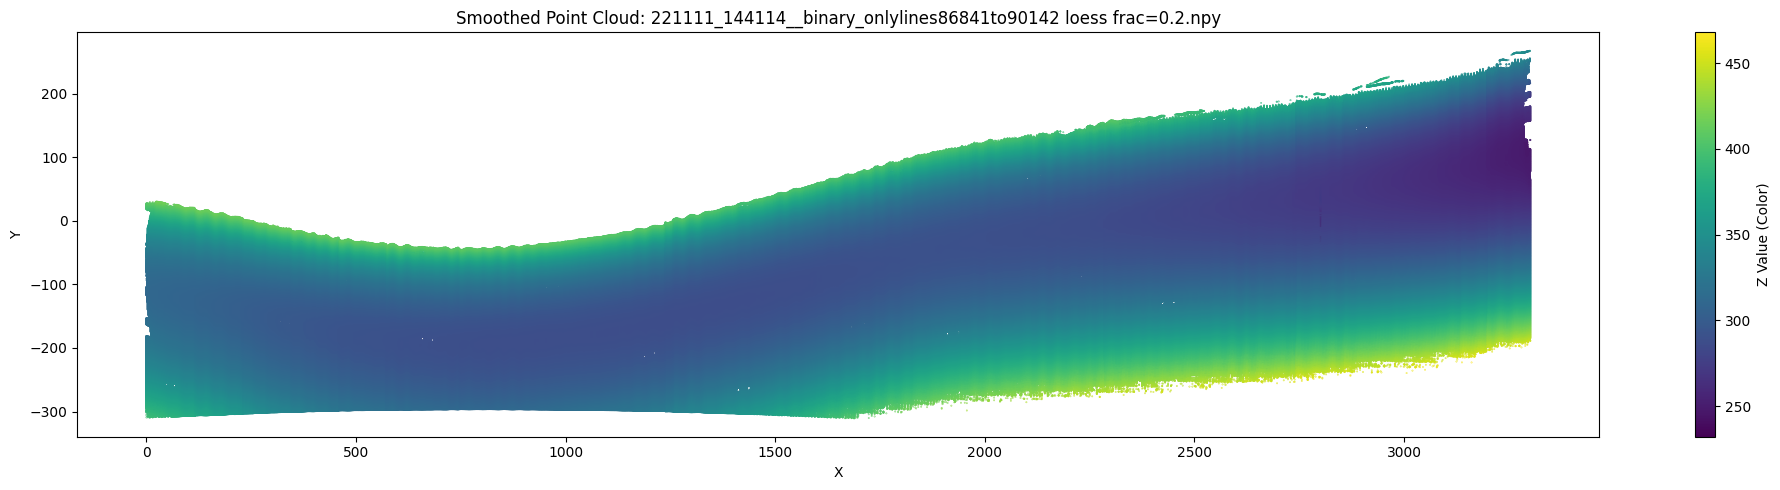

In [10]:
for cloud, fname in zip(smoothed_point_clouds, npy_files):
    if cloud.shape[0] == 3:  # If shape is (3, N), transpose to (N, 3)
        cloud = cloud.T
    x = cloud[:, 0]
    y = cloud[:, 1]
    z = cloud[:, 2]
    plt.figure(figsize=(20, 5))
    sc = plt.scatter(x, y, c=z, s=0.1, cmap='viridis')
    plt.title(f"Smoothed Point Cloud: {fname}")
    plt.xlabel("X")
    plt.ylabel("Y")
    cbar = plt.colorbar(sc)
    cbar.set_label("Z Value (Color)")
    plt.tight_layout()
    plt.show()

Rendering the orginal scans

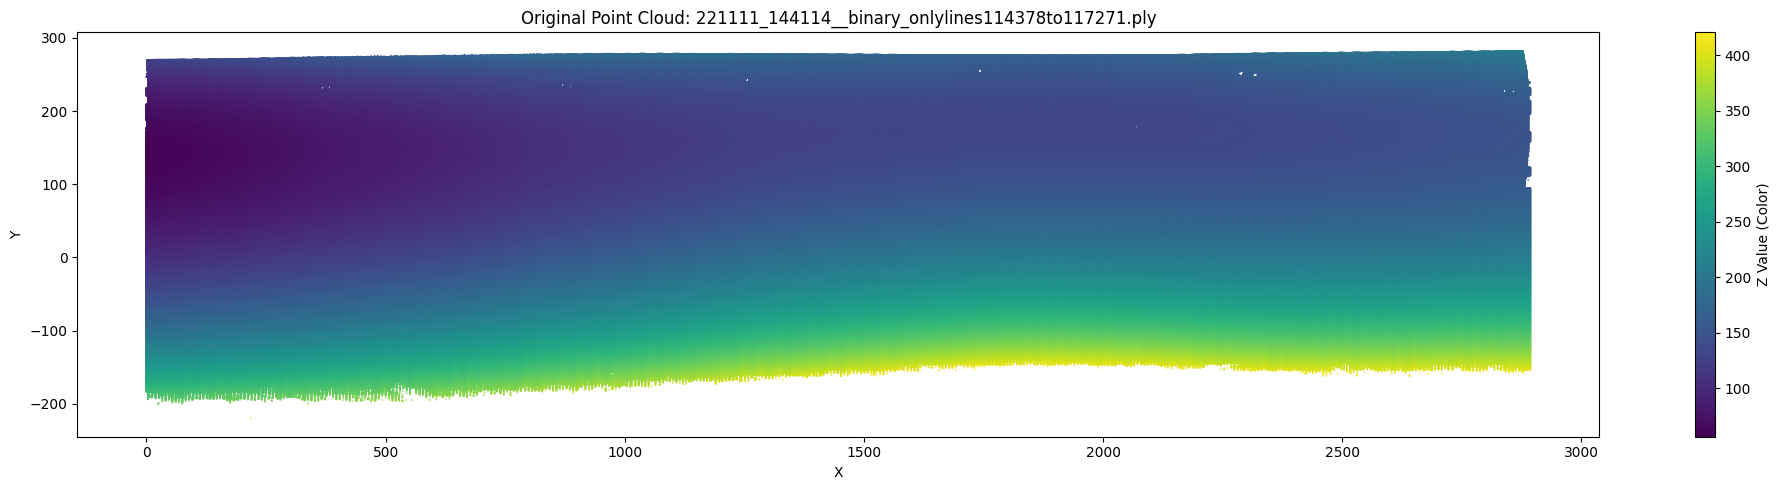

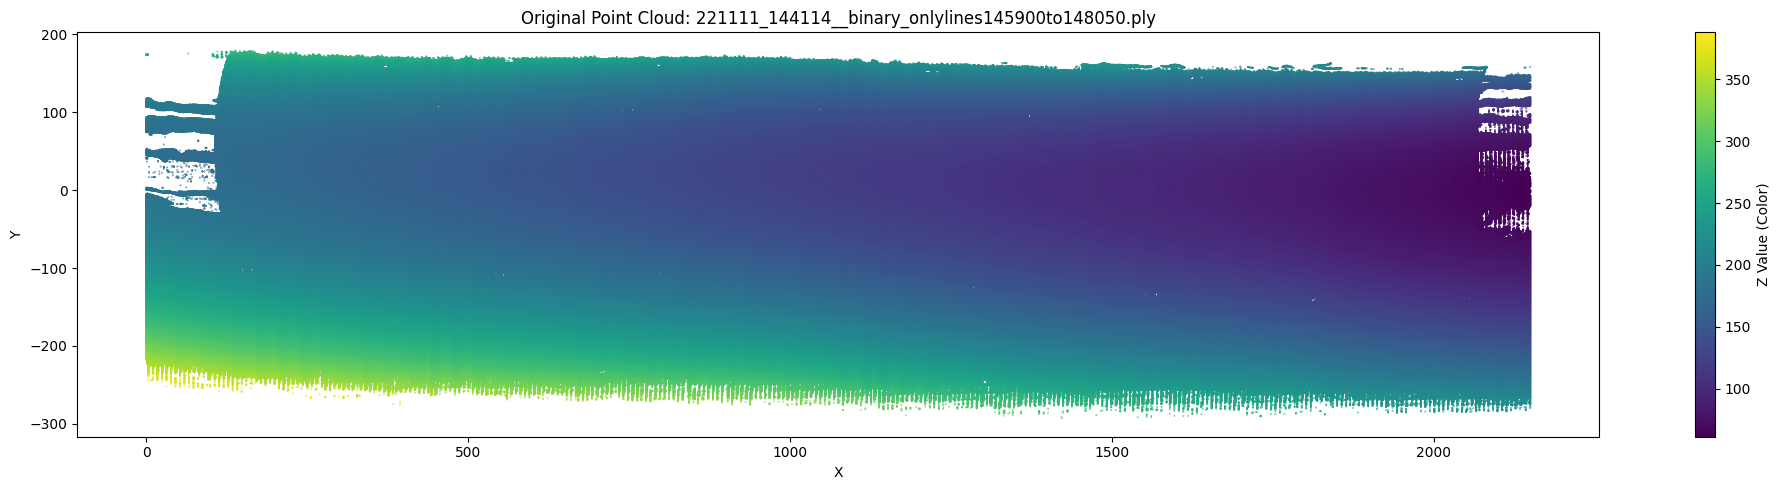

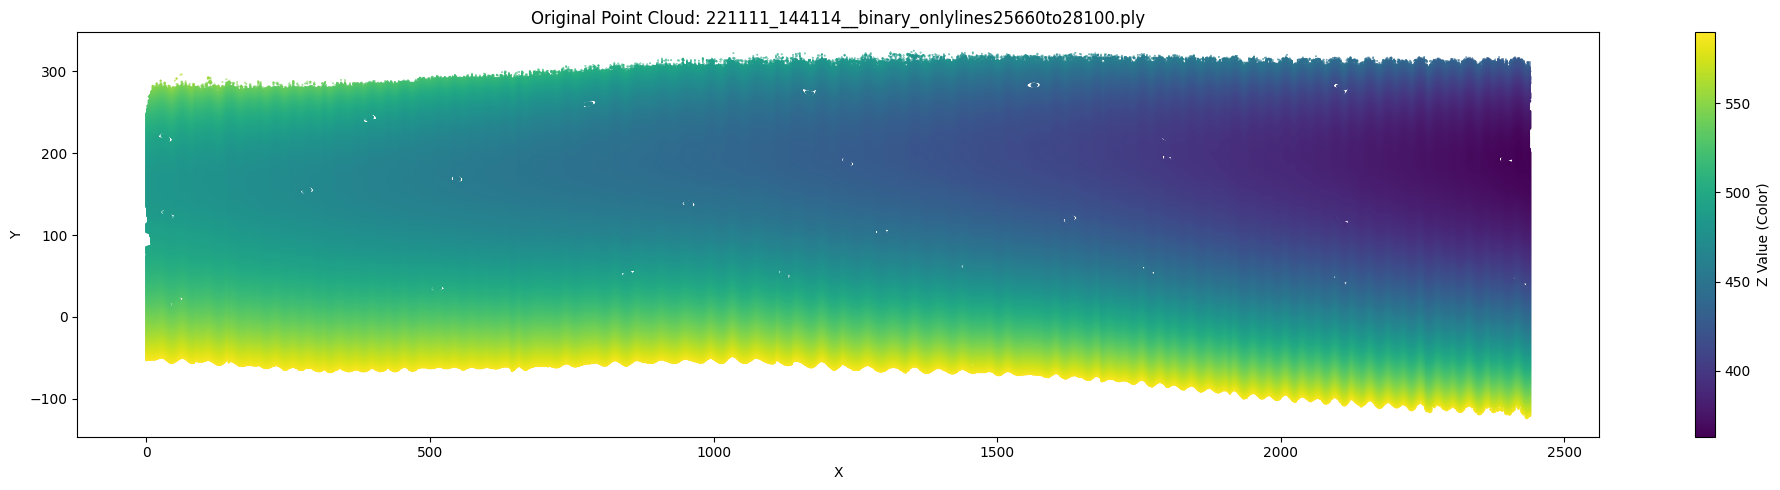

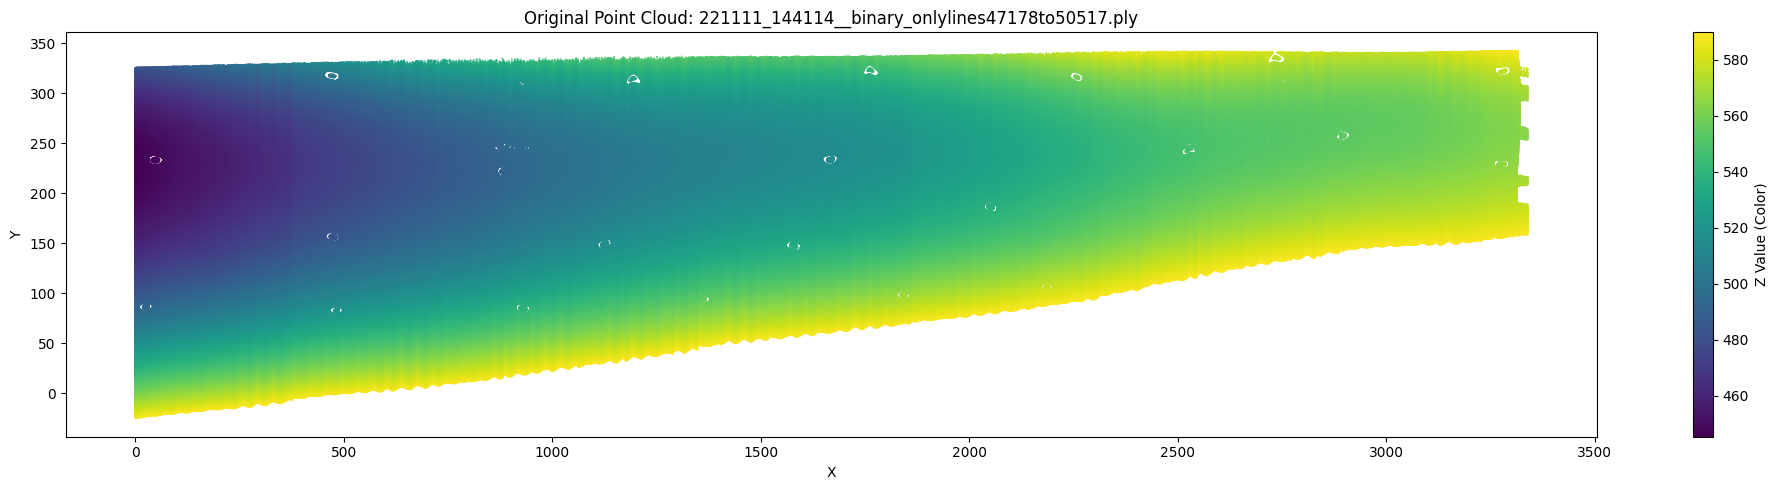

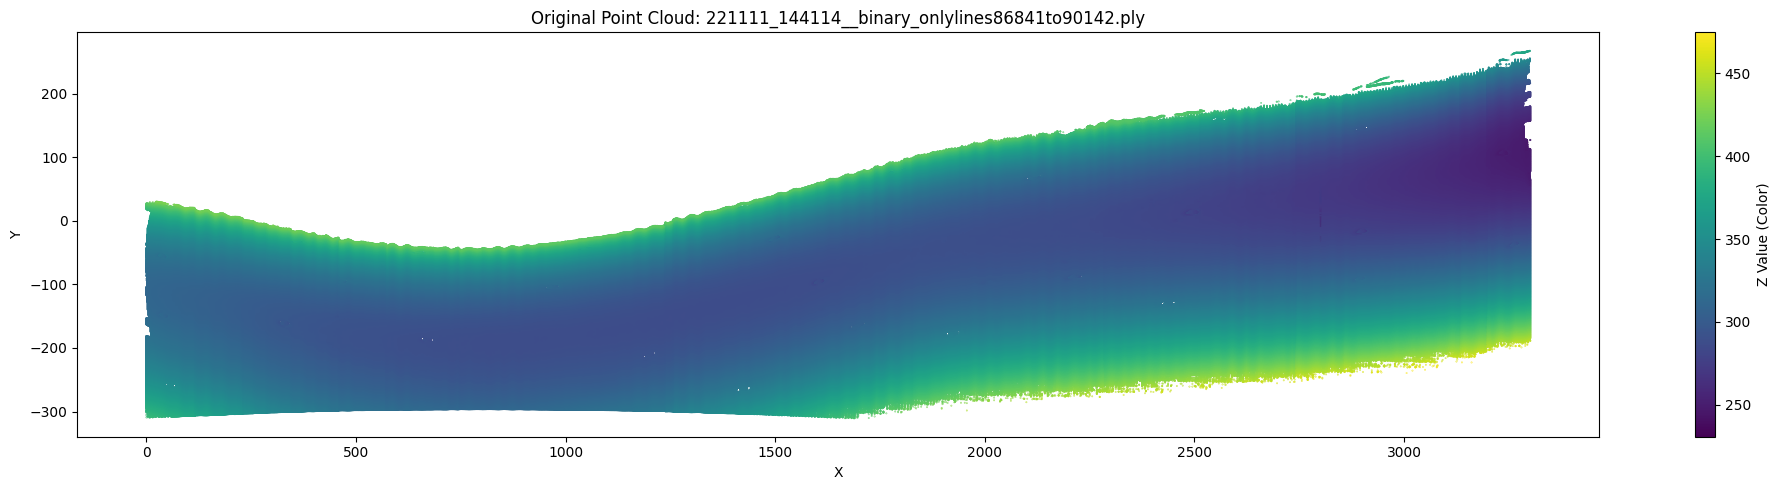

In [11]:
for points, fname in zip(offset_point_clouds, ply_files):
    if points.shape[0] == 3:  # If shape is (3, N), transpose to (N, 3)
        points = points.T
    x = points[:, 0]
    y = points[:, 1]
    z = points[:, 2]
    plt.figure(figsize=(20, 5))
    sc = plt.scatter(x, y, c=z, s=0.1, cmap='viridis')
    plt.title(f"Original Point Cloud: {fname}")
    plt.xlabel("X")
    plt.ylabel("Y")
    cbar = plt.colorbar(sc)
    cbar.set_label("Z Value (Color)")
    plt.tight_layout()
    plt.show()

# Calculating the difference
Here I calculate the difference between the smoothed and original scans along the Z axis

In [12]:
diff_point_clouds = []
for smoothed, original in zip(smoothed_point_clouds, offset_point_clouds):
    # Ensure both arrays are (N, 3)
    if smoothed.shape[0] == 3:
        smoothed = smoothed.T
    if original.shape[0] == 3:
        original = original.T

    # Find the minimum number of points to avoid shape mismatch
    n_points = min(smoothed.shape[0], original.shape[0])
    smoothed = smoothed[:n_points]
    original = original[:n_points]

    # Compute the difference on the Z axis
    diff = smoothed.copy()
    diff[:, 2] = smoothed[:, 2] - original[:, 2]
    diff_point_clouds.append(diff)

Let's render the new pointclouds.

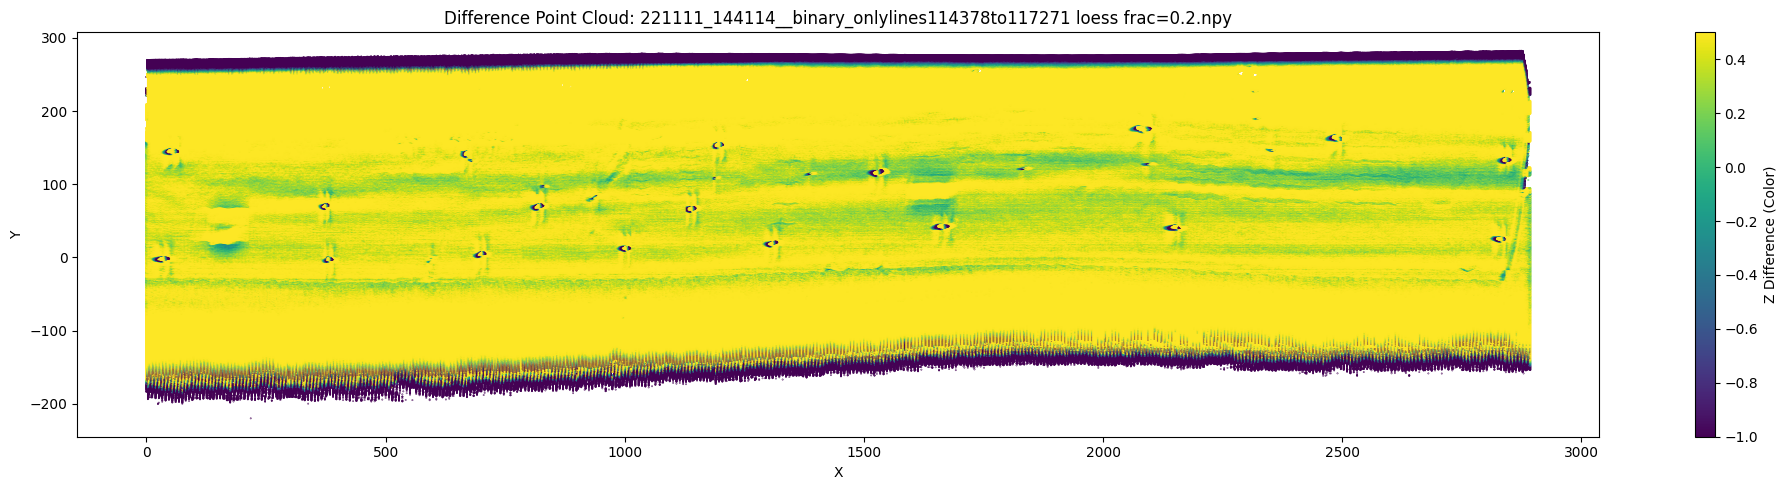

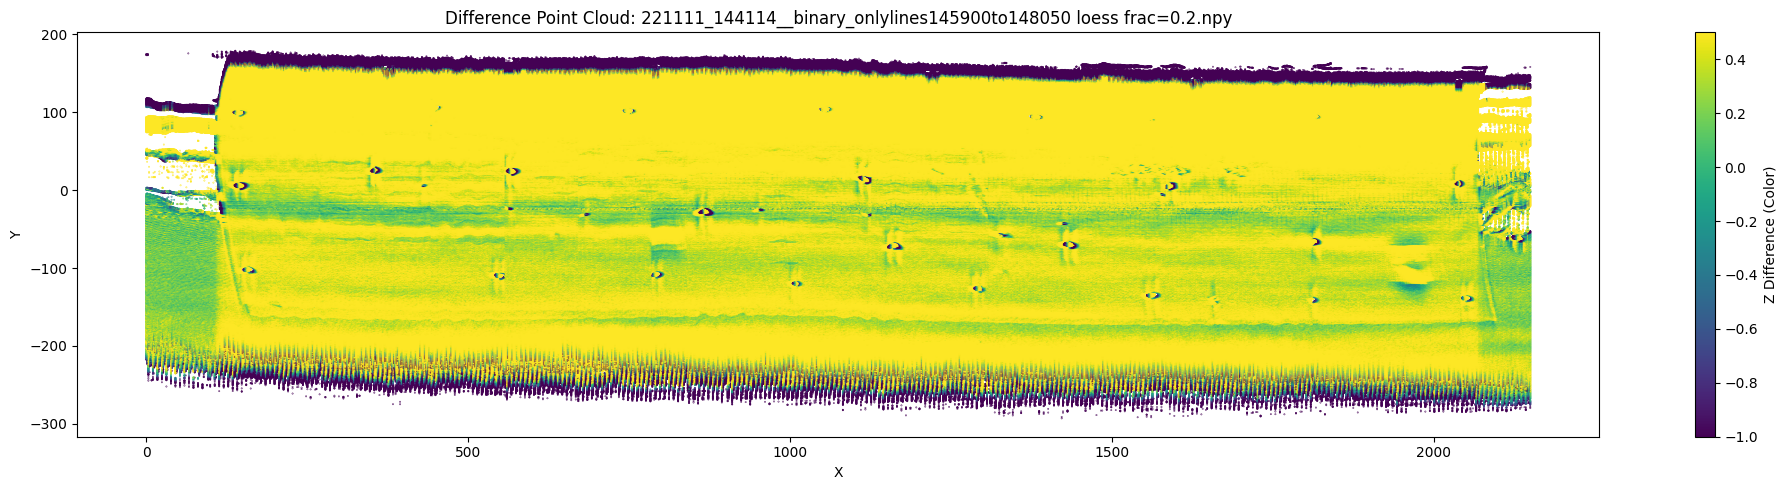

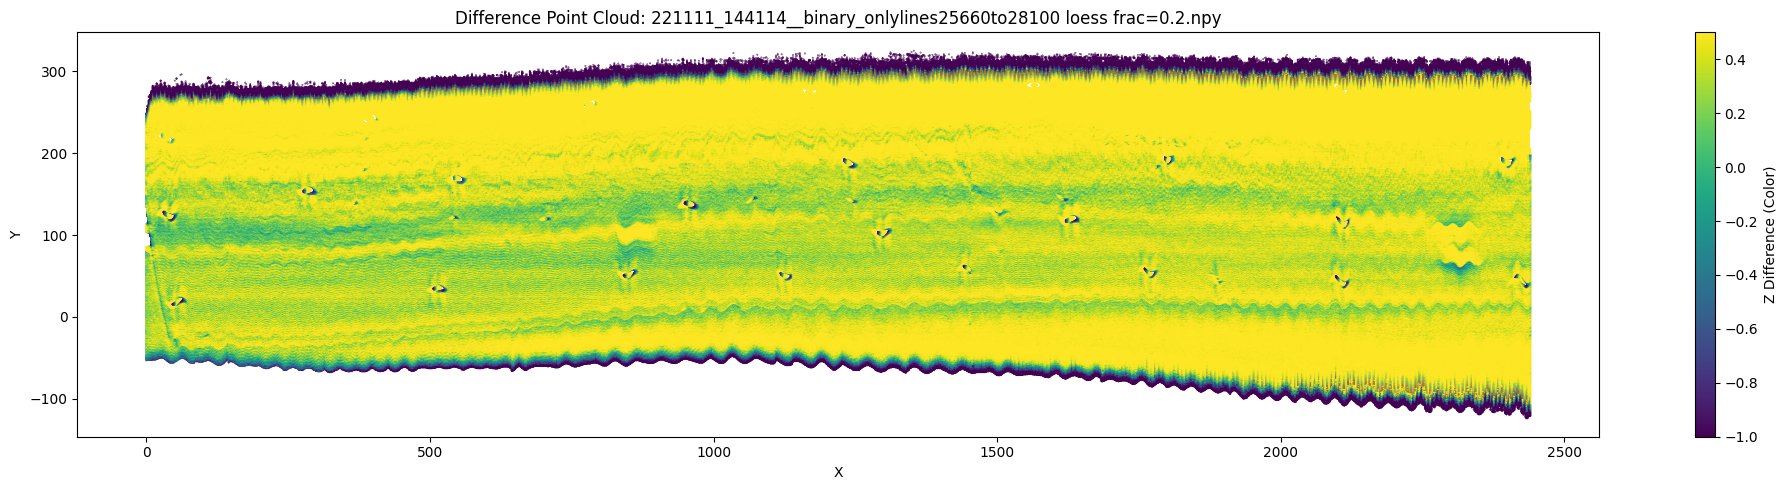

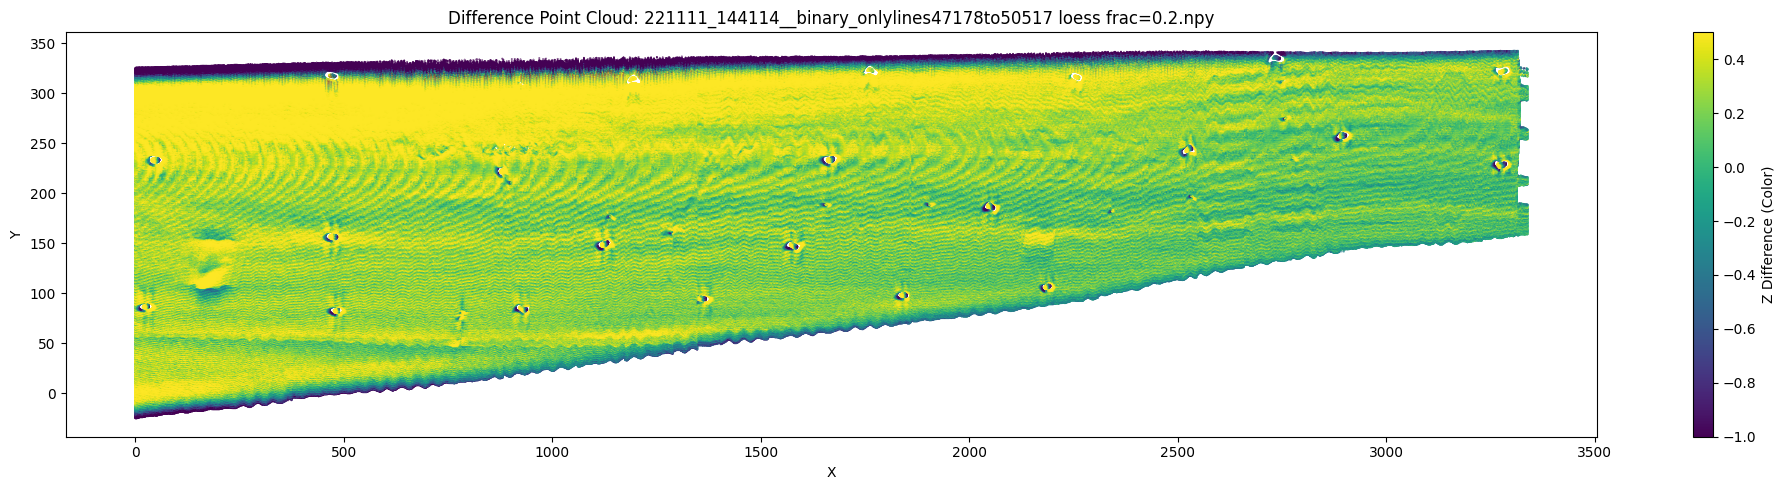

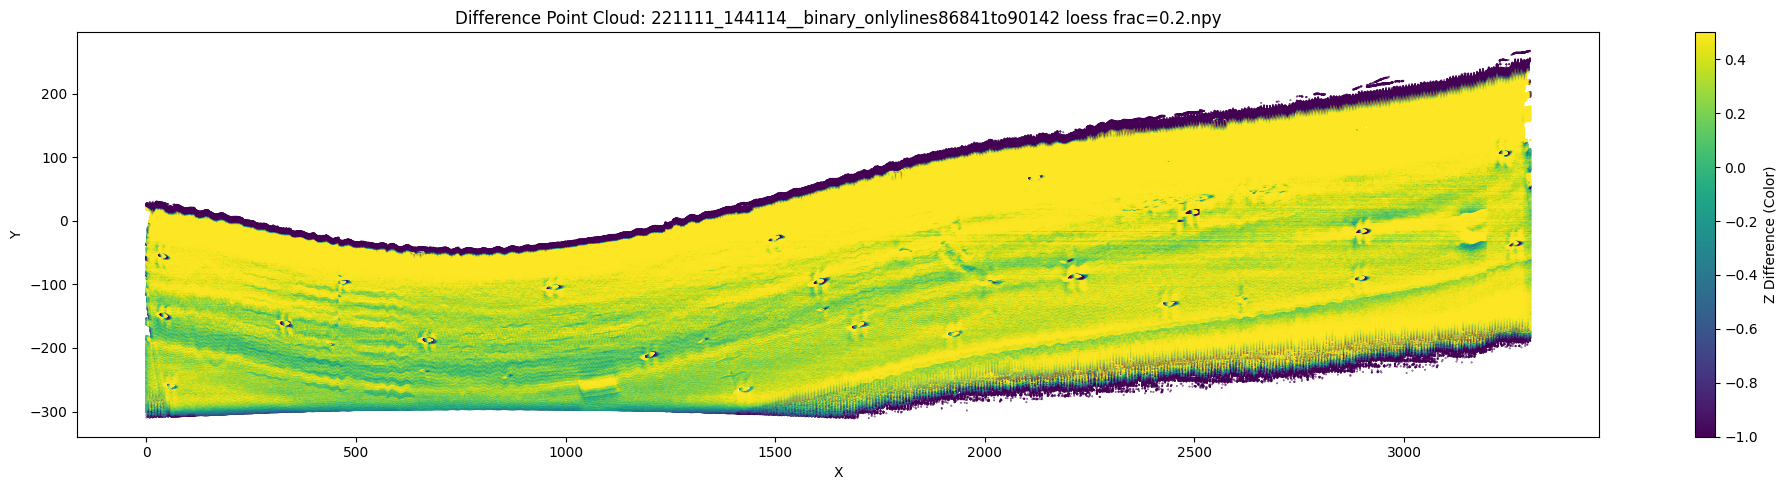

In [13]:
for diff_cloud, fname in zip(diff_point_clouds, npy_files):
    x = diff_cloud[:, 0]
    y = diff_cloud[:, 1]
    z = diff_cloud[:, 2]
    plt.figure(figsize=(20, 5))
    sc = plt.scatter(x, y, c=z, s=0.1, vmin=-1, vmax=0.5)
    plt.title(f"Difference Point Cloud: {fname}")
    plt.xlabel("X")
    plt.ylabel("Y")
    cbar = plt.colorbar(sc)
    cbar.set_label("Z Difference (Color)")
    plt.tight_layout()
    plt.show()

# Saving the difference pointclouds

In [14]:
diff_dir = smoothed_dir.replace("smoothed", "difference")
os.makedirs(diff_dir, exist_ok=True)

for diff_cloud, fname in zip(diff_point_clouds, npy_files):
    outname = os.path.splitext(fname)[0] + "_difference.npy"
    outpath = os.path.join(diff_dir, outname)
    np.save(outpath, diff_cloud)
    print(f"Saved: {outpath}")

Saved: ../scandata/difference loess frac=0.20/221111_144114__binary_onlylines114378to117271 loess frac=0.2_difference.npy
Saved: ../scandata/difference loess frac=0.20/221111_144114__binary_onlylines145900to148050 loess frac=0.2_difference.npy
Saved: ../scandata/difference loess frac=0.20/221111_144114__binary_onlylines25660to28100 loess frac=0.2_difference.npy
Saved: ../scandata/difference loess frac=0.20/221111_144114__binary_onlylines47178to50517 loess frac=0.2_difference.npy
Saved: ../scandata/difference loess frac=0.20/221111_144114__binary_onlylines86841to90142 loess frac=0.2_difference.npy
